<a href="https://colab.research.google.com/github/MazonSzymon/modelowanie_cen_akcji_spolek/blob/main/Praca_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#  ***Modelowanie  cen  (zwrotów  ceny)  akcji  spółek:  Alior Bank, mBank, Dino Polska, CD Projekt  przy  użyciu  modeli szeregów czasowych ARMA, ARIMA*** 

---

#Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader as pdr 
%load_ext google.colab.data_table
import math
import fbprophet
from scipy.stats import boxcox
import matplotlib.dates as mdates
from scipy.special import inv_boxcox
from matplotlib.ticker import StrMethodFormatter
from fbprophet.diagnostics import cross_validation

#Set up plot
from cycler import cycler
plt.style.use('ggplot')
plt.rc('axes', facecolor='white', edgecolor='black', grid = False, axisbelow = True)
plt.rc('grid',color='gray', linestyle='solid', linewidth=0.5)
plt.rc('patch', edgecolor='black')
plt.rc('legend', shadow=True, handlelength=1, fontsize=10, edgecolor = 'black', facecolor='white')

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [26]:
!git clone https://github.com/MazonSzymon/modelowanie_cen_akcji_spolek.git
import sys
sys.path.append('/content/modelowanie_cen_akcji_spolek/')

Cloning into 'modelowanie_cen_akcji_spolek'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


# Stooq data

>## Stocks company list




In [15]:
our_stocks = pd.DataFrame(np.array([
                                    ['WI20','wig20.pl'],
                                    ['Alior Bank','alr.pl'],
                                    ['CD Projekt', 'cdr.pl'],
                                    ['Dino Polska', 'dnp.pl'],
                                    ['mBank', 'mbk.pl']
]), columns = ['Full_name','Stoq_name'])



>## Download data and main DataFrame functions



In [19]:
def get_data(stock,start_date, end_date):
  stooq_data = pdr.get_data_stooq(stock['Stoq_name'], start = start_date, end = end_date).sort_index()
  stooq_data['Stock_name'] = stock['Full_name']
  df = stooq_data.copy()
  return df

In [17]:
def creat_WIG20_frame(start_date,end_date,stocks_list):
  WIG20 = pd.DataFrame()
  for i in range(len(stocks_list)):
    tmp = get_data(stocks_list.iloc[i],start_date,end_date)
    WIG20 = WIG20.append(tmp)
  return WIG20



>## Main DataFrame



>> ### Creat main DataFrame





In [20]:
start_date = dt.date(2015,1,1)
end_date = dt.date.today()
#df = creat_WIG20_frame(start_date,end_date,our_stocks) #API, dont run many times!

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6744 entries, 2015-01-02 to 2020-11-06
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        6744 non-null   float64
 1   High        6744 non-null   float64
 2   Low         6744 non-null   float64
 3   Close       6744 non-null   float64
 4   Volume      6744 non-null   int64  
 5   Stock_name  6744 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 368.8+ KB


In [24]:
df.drop( columns= ['Open','High','Low','Volume'],inplace = True)
df['Stock_name'] = df['Stock_name'].astype('category')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6744 entries, 2015-01-02 to 2020-11-06
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Close       6744 non-null   float64 
 1   Stock_name  6744 non-null   category
dtypes: category(1), float64(1)
memory usage: 112.2 KB


>> ### Data Visualization

 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



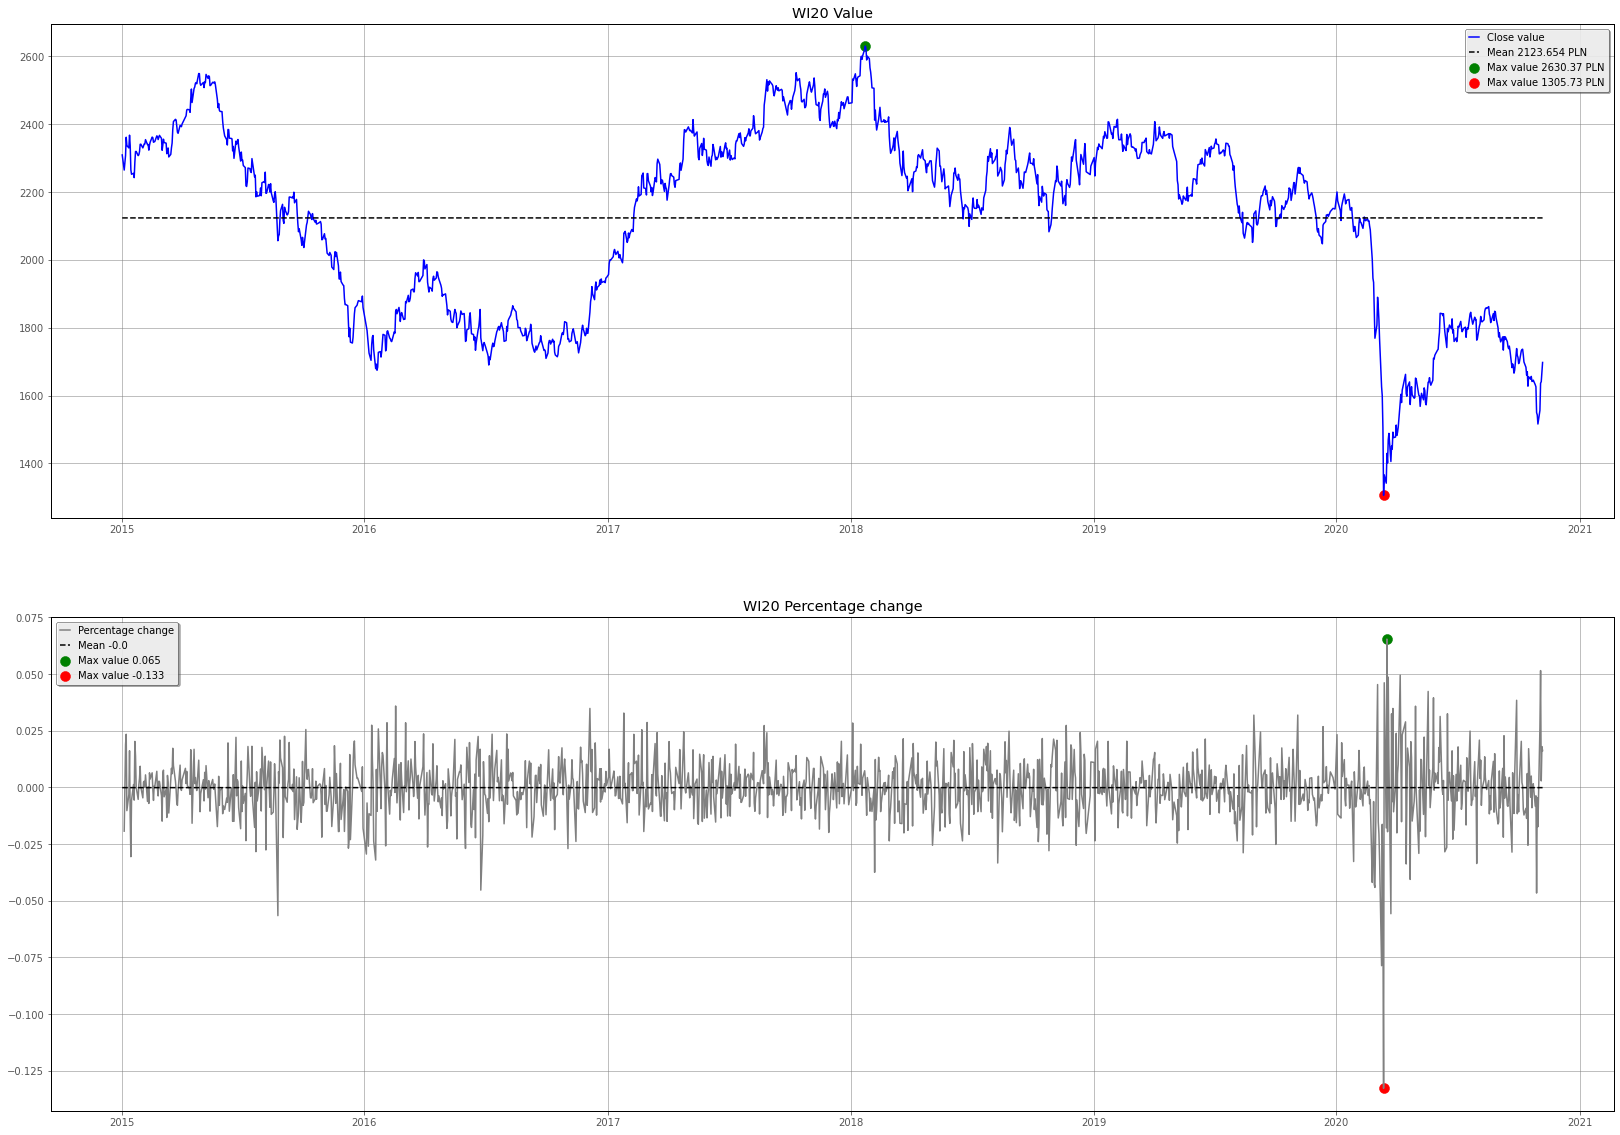

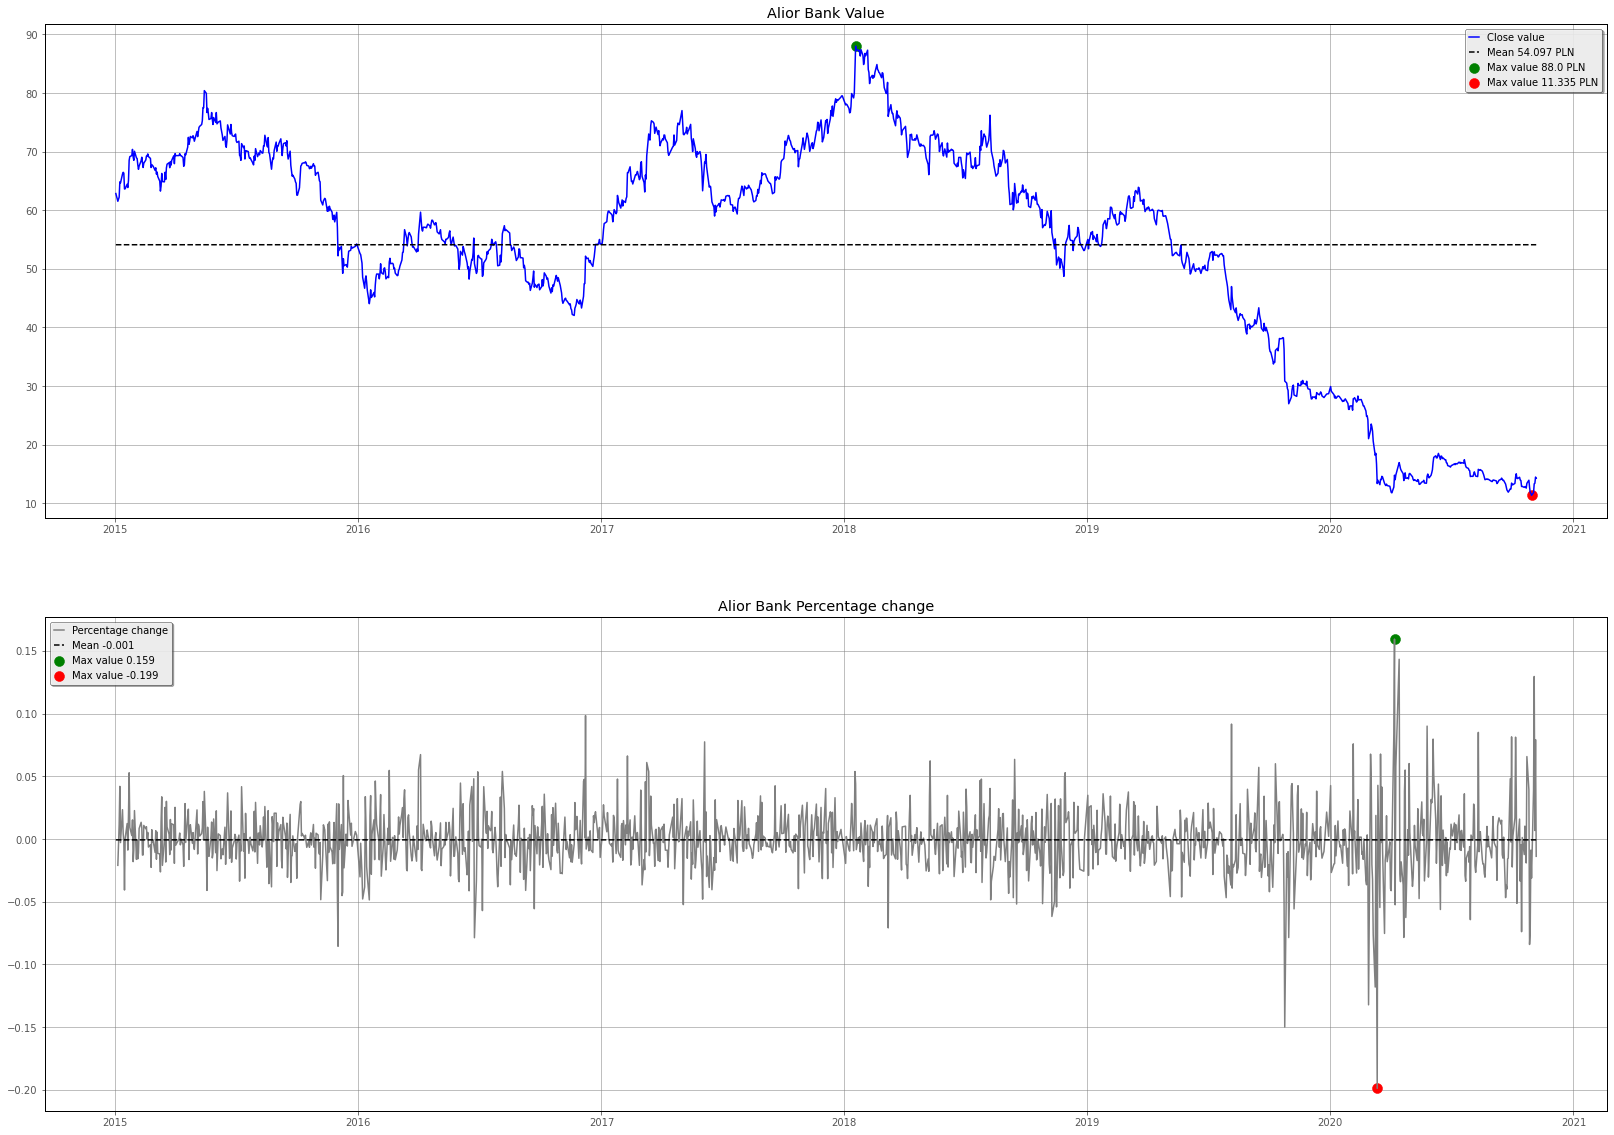

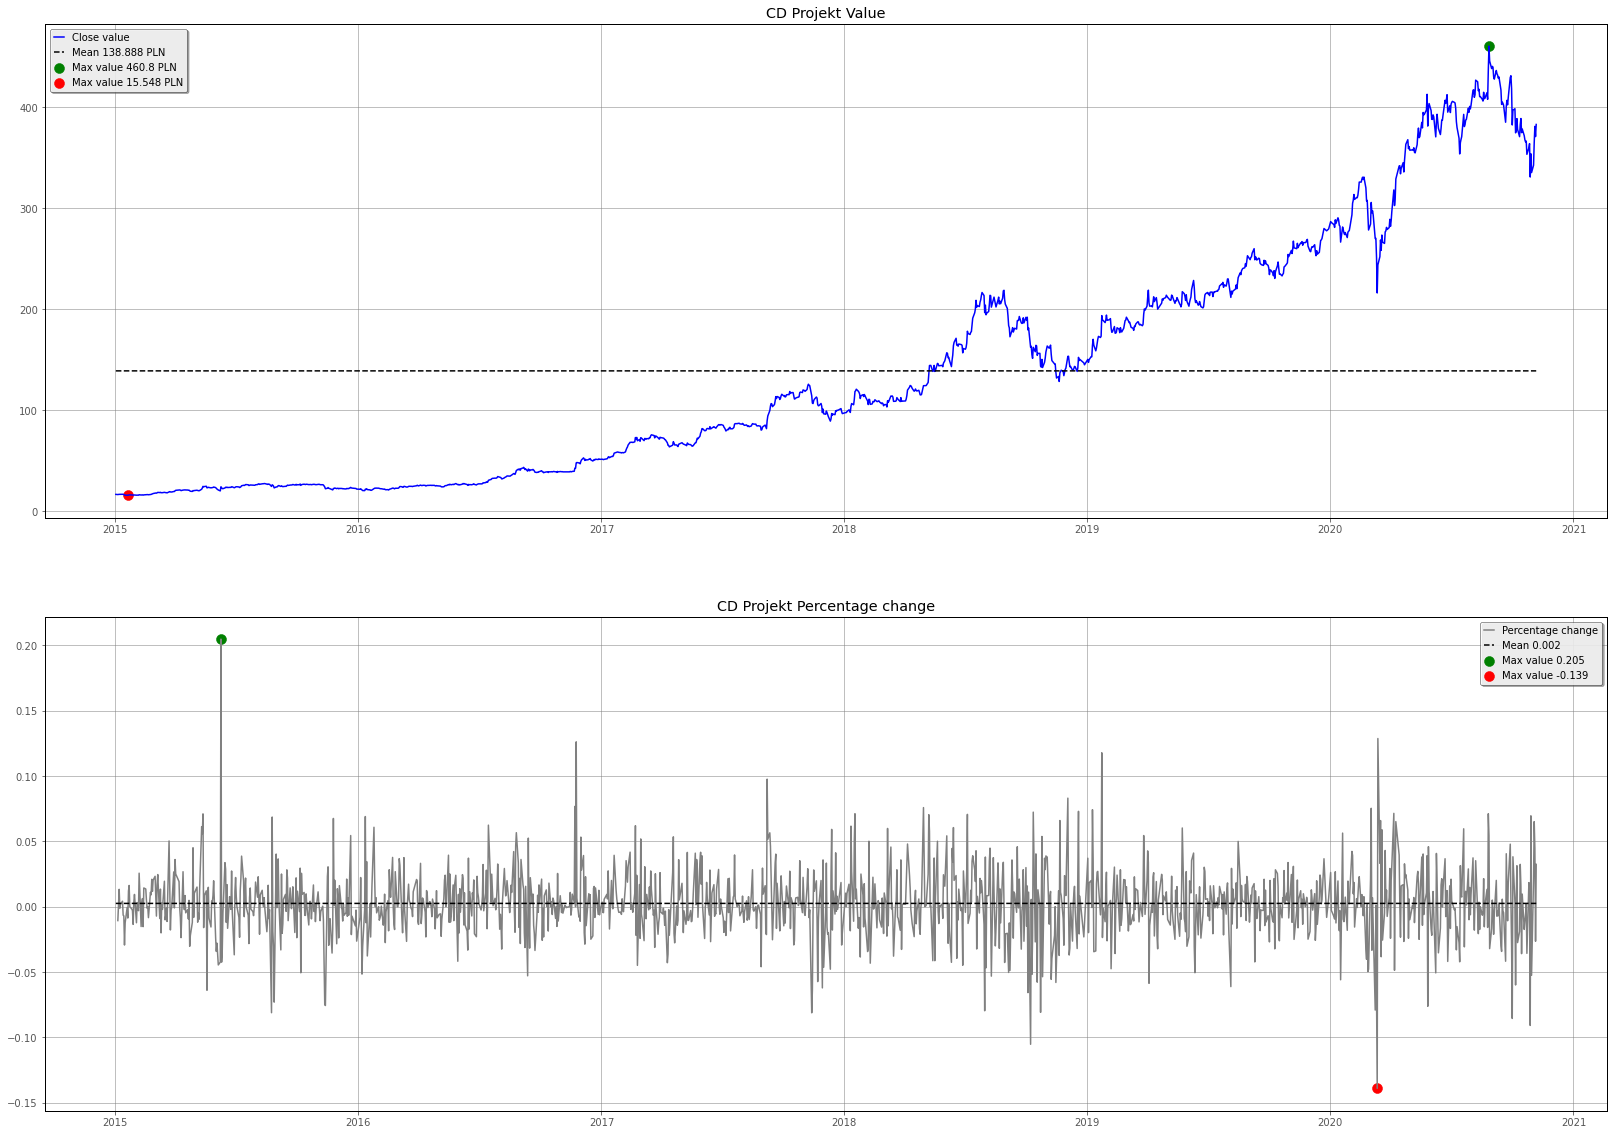

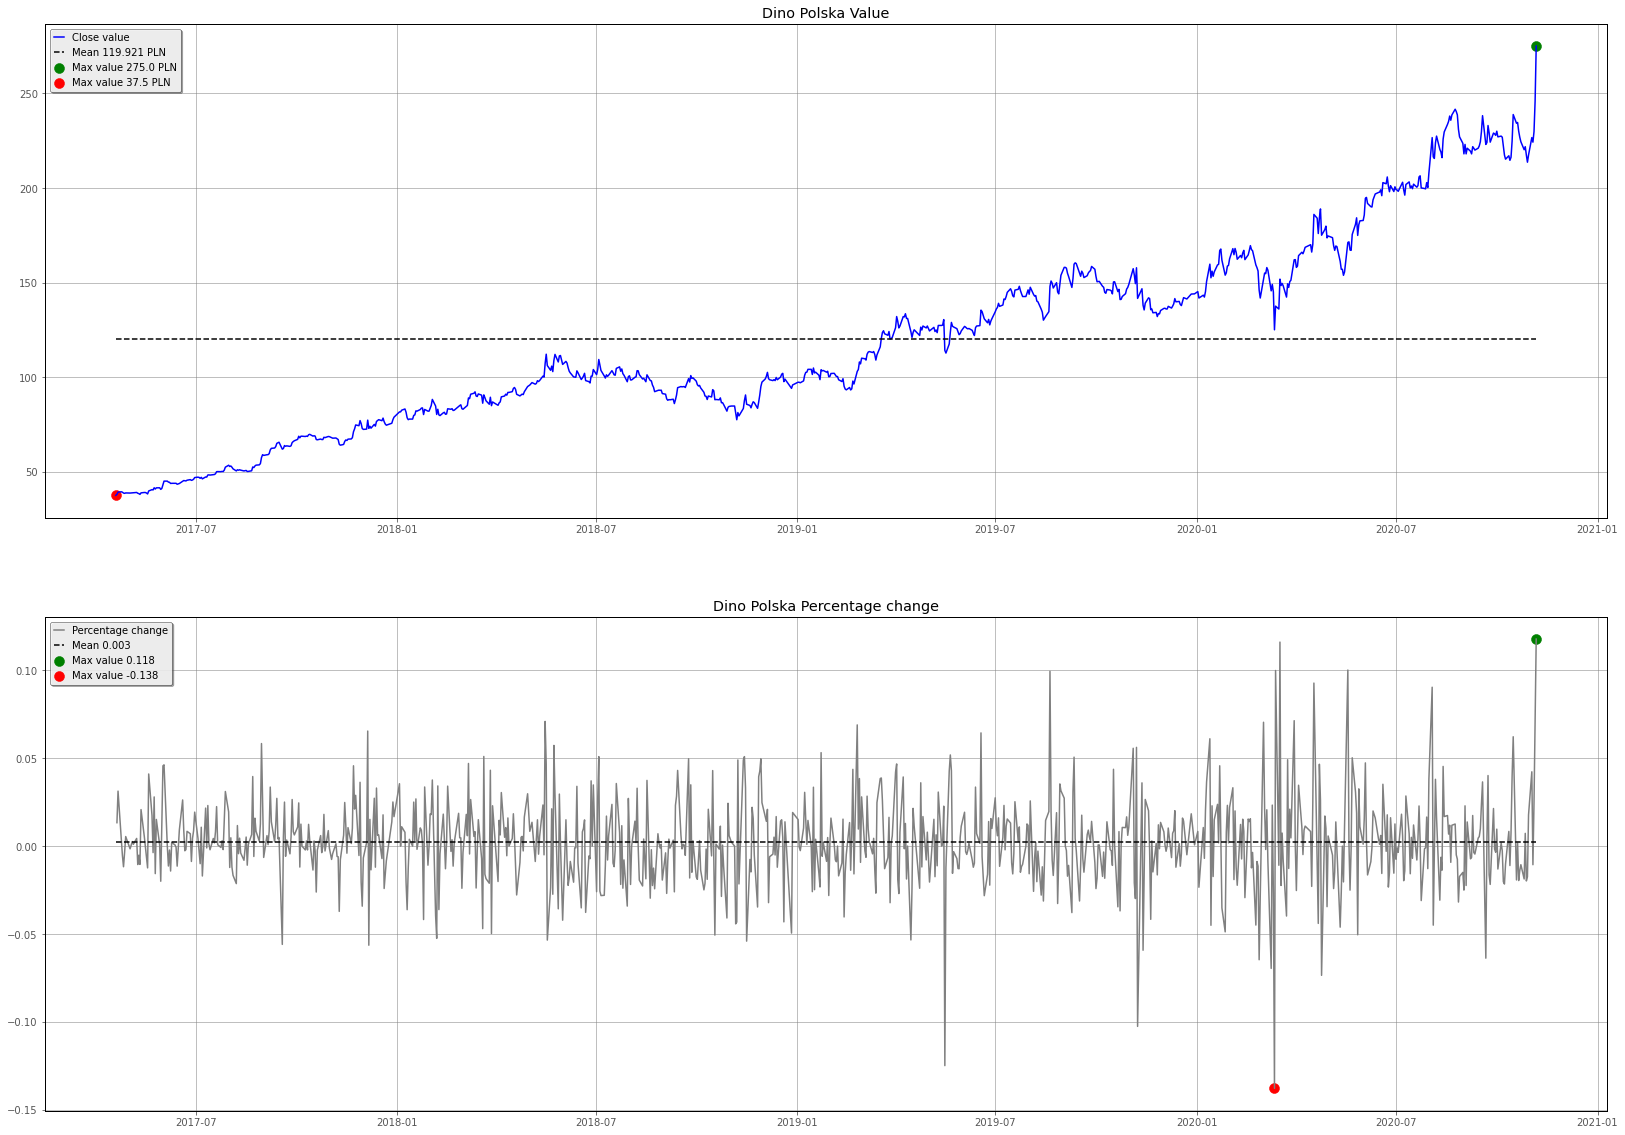

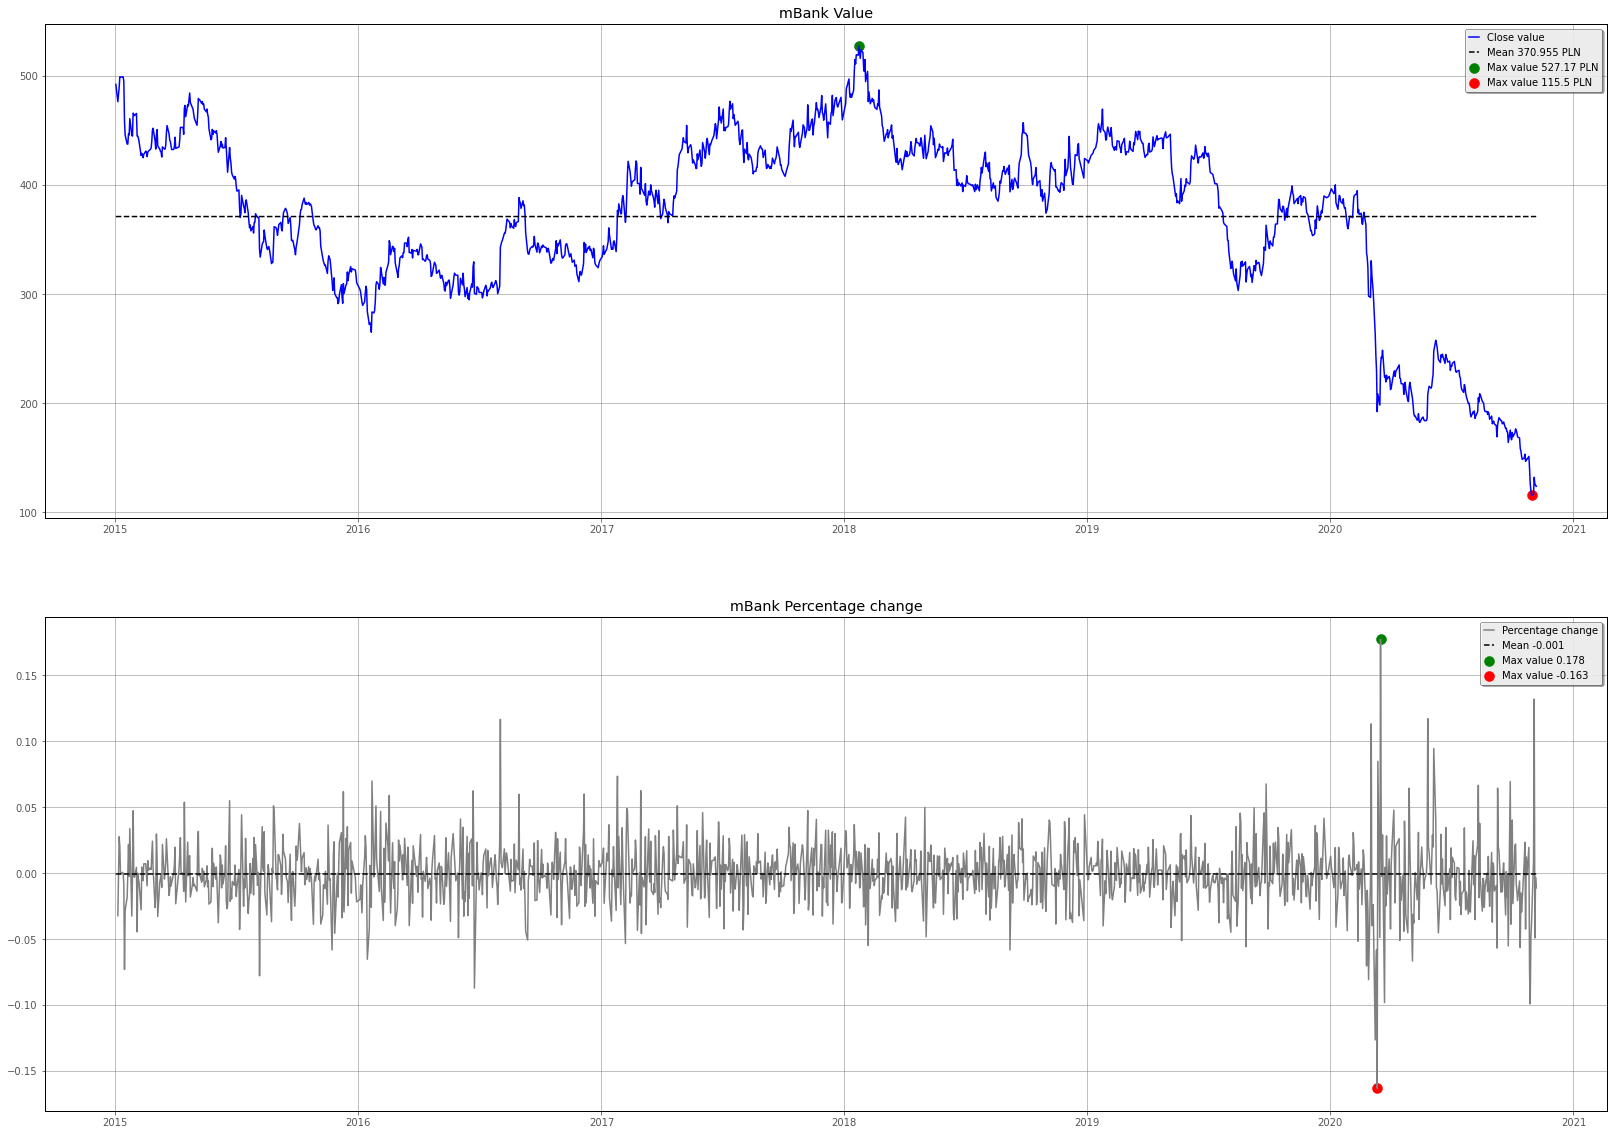

In [135]:
for i in range(df['Stock_name'].nunique()):
  tmp = df[df['Stock_name'] == df['Stock_name'].unique()[i]]
  tmp['Mean'] = tmp['Close'].mean()
  tmp['Mean_pct_change'] = tmp['Close'].pct_change().mean()
  plt.figure(figsize=(28,20))
  #Stock value
  plt.subplot(2,1,1)
  plt.plot(tmp['Close'],color = 'blue',label = 'Close value')
  plt.plot(tmp['Mean'], color = 'black',linestyle='dashed', label = 'Mean ' + str(tmp['Mean'].values[0].round(3)) + " PLN")
  plt.scatter(tmp['Close'].idxmax(), tmp['Close'].max(), color = 'green', s=100, label = 'Max value ' + str(tmp['Close'].max()) + " PLN")
  plt.scatter(tmp['Close'].idxmin(), tmp['Close'].min(), color = 'red', s=100, label = 'Max value ' + str(tmp['Close'].min()) + " PLN")
  plt.title(df['Stock_name'].unique()[i] + ' Value')
  plt.legend()
  plt.grid()
  #Stock value percentage change
  plt.subplot(2,1,2)
  plt.plot(tmp['Close'].pct_change(), color = 'gray', label = 'Percentage change')
  plt.plot(tmp['Mean_pct_change'], color = 'black',linestyle='dashed', label = 'Mean ' + str(tmp['Mean_pct_change'].values[0].round(3)))
  plt.scatter(tmp['Close'].pct_change().idxmax(), tmp['Close'].pct_change().max(), color = 'green', s=100, label = 'Max value ' + str(tmp['Close'].pct_change().round(3).max()))
  plt.scatter(tmp['Close'].pct_change().idxmin(), tmp['Close'].pct_change().min(), color = 'red', s=100, label = 'Max value ' + str(tmp['Close'].pct_change().round(3).min()))
  plt.title(df['Stock_name'].unique()[i] + ' Percentage change')
  plt.grid()
  plt.legend()
  plt.show()
  print(2*"\n")